<a href="https://colab.research.google.com/github/Sicily-F/Trade-Chirps/blob/master/20_species_Transfer_learning_with_a_headless_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q keras

In [ ]:
!pip install tensorflow-gpu

In [ ]:
import keras
import numpy as np	
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import PIL#added in from first tutorial
import pathlib
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True#to load truncated images from augmentation -  see here: https://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images

import os

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
data_root = '/content/drive/My Drive/Colab Notebooks/Twenty photos with augmentation' #need to add in the Google Drive directory


Can't read all the files in the folder, post augmentation, so tried the below code from here: https://stackoverflow.com/questions/63754311/unidentifiedimageerror-cannot-identify-image-file

In [ ]:
folder_path = '/content/drive/My Drive/Colab Notebooks/Twenty photos with augmentation' #need to add in the Google Drive directory
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

In [ ]:
print(data_root)

/content/drive/My Drive/Colab Notebooks/Twenty photos with augmentation


In [ ]:
IMAGE_SHAPE = (224, 224) 

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)


for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


Found 4964 images belonging to 20 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 20)


First try was Inception Rest Net, now with inception version 3: https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4, https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4
https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1

next please try: https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4


In [ ]:
feature_extractor_model = 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4'#try with inception as well

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)


In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              58331648  
_________________________________________________________________
dense (Dense)                (None, 20)                40980     
Total params: 58,372,628
Trainable params: 40,980
Non-trainable params: 58,331,648
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()
    

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=30,#5 with augmentation, just as an initial trial
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])



Epoch 1/30
156/156 [==============================] - 2559s 16s/step - loss: 1.0220 - acc: 0.7500
Epoch 2/30
156/156 [==============================] - 342s 2s/step - loss: 0.7635 - acc: 0.7812
Epoch 3/30
156/156 [==============================] - 318s 2s/step - loss: 0.3631 - acc: 0.9375
Epoch 4/30
156/156 [==============================] - 319s 2s/step - loss: 0.6960 - acc: 0.7812
Epoch 5/30
156/156 [==============================] - 319s 2s/step - loss: 0.3578 - acc: 0.8750
Epoch 6/30
156/156 [==============================] - 328s 2s/step - loss: 0.1977 - acc: 0.9688
Epoch 7/30
156/156 [==============================] - 323s 2s/step - loss: 0.2087 - acc: 0.9688
Epoch 8/30
156/156 [==============================] - 321s 2s/step - loss: 0.1267 - acc: 1.0000
Epoch 9/30
156/156 [==============================] - 321s 2s/step - loss: 0.2250 - acc: 0.9688
Epoch 10/30
156/156 [==============================] - 317s 2s/step - loss: 0.1333 - acc: 1.0000
Epoch 11/30
156/156 [================

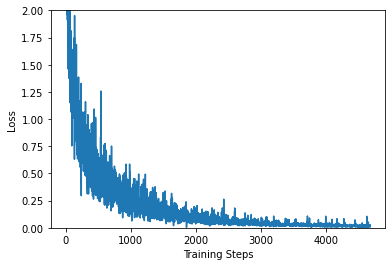

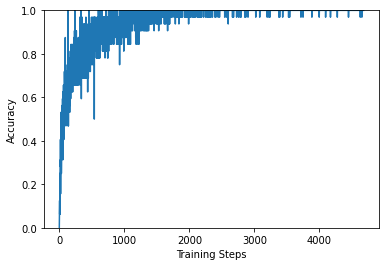

In [ ]:
#how much progress is the model making on our task: acc: 0.8438

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
# ^^^^^after about 20 training steps, there was a big change in the accuracy


In [ ]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

#this, I think, links the arrows and their labels to the photos,
#from the predictions

predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)


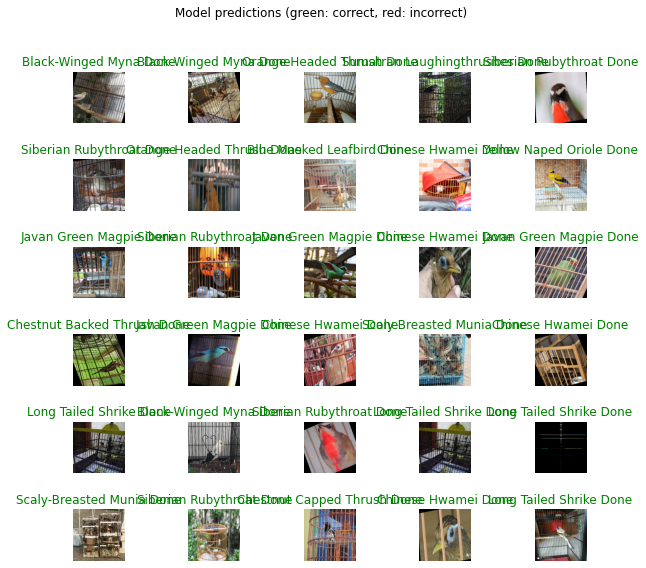

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.7) #currently can't read the image title
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Using Inception Resnet - V2 on unaugmented data

*   21.11/20 :  20 species on 8 epochs: 0.8438 accuracy, input: 256, 256
*  21.11.20 :  20 species on 15 epochs: 0.9688 accuracy, input: 256, 256


# Using Inception- V3 on unaugmented data

*   22.11.20: 20 species on 15 epochs, achieved 0.8125,
 input:  299, 299

# Using Efficient Net on unaugmented data


*   22.11.20 : 20 species on 15 epochs: above 0.9688, input: 380, 380
*   Made 30 predictions, only one of them was wrong
*   around 5 hours of run time at least

# Using Mobile Net on unaugmented data


*   22.11.20: 20 species on 15 epochs: above 0.9688, input 90, 90
*   Made 30 predictions, all of them were correct

# Using Inception Resnet - V2 on augmented data

*   30.11.20 :  20 species on 5 epochs: 0.6875 accuracy, input: 224, 224
*  30.11.20 :  20 species on 15 epochs:  loss: 0.0718, 1.0000 accuracy, input: 224, 224, 320 seconds per epoch
* 01.12.20 : 20 species on 30 epochs: 307s 2s/step - loss: 0.0231 - acc: 1.000, input: 224, 224
















